In [1]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
import pickle
import wind_power_bidding as wpb

In [2]:
# Load the forecast data
with open('InputData/Scenarios.pkl', 'rb') as file:
    data = pickle.load(file)
wind_forecast = data['wind_data_da']
spot_forecast = data['spot_prices']
# spot_forecast = np.ones(np.shape(spot_forecast))
imbalance_forecast = data['imbalance']
n1=20; n2=20; n3=4; n_scenarios = [n1,n2,n3]
print(np.shape(wind_forecast))
print(np.shape(spot_forecast))
print(np.shape(imbalance_forecast))

f_up= 1.25
f_down = 0.85

(24, 20)
(24, 20)
(24, 4)


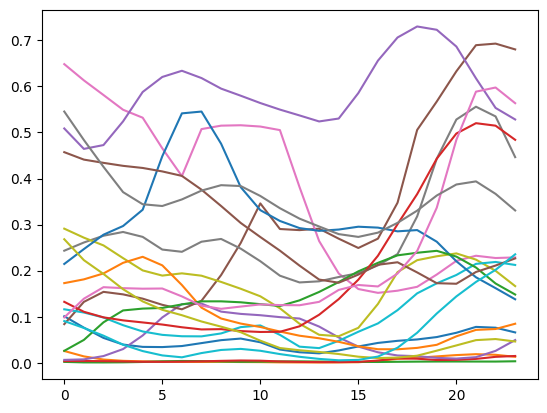

In [3]:
plt.plot(wind_forecast, label='Wind Forecast')

# 1) One price scheme

In [4]:
# combine scenarios and shuffle them 
import itertools

combined_scenarios = list(itertools.product(range(n1), range(n2), range(n3)))
shuffled_scenarios = np.random.permutation(combined_scenarios)

In [5]:
# nb_scenarios to consider
n_scenarios = 100
scenarios_id = shuffled_scenarios[:n_scenarios, :] # take the first n_scenarios as the in-sample scenarios
wind_bids, prob, imbalances, imbalances_up, imbalances_down= wpb.wind_pp_bidding(wind_forecast[:, scenarios_id[:, 0]], spot_forecast[:, scenarios_id[:, 1]], imbalance_forecast[:, scenarios_id[:, 2]], f_up, f_down, price_scheme='one_price')

/opt/homebrew/lib/python3.11/site-packages/cvxpy/problems/problem.py:158: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "


Objective value:  433.02788169952834


/opt/homebrew/lib/python3.11/site-packages/mosek/__init__.py:18617: UserWarning: Argument sub in putvarboundlist: Incorrect array format causing data to be copied
  warnings.warn("Argument sub in putvarboundlist: Incorrect array format causing data to be copied");
/opt/homebrew/lib/python3.11/site-packages/mosek/__init__.py:18925: UserWarning: Argument subj in putclist: Incorrect array format causing data to be copied
  warnings.warn("Argument subj in putclist: Incorrect array format causing data to be copied");
/opt/homebrew/lib/python3.11/site-packages/mosek/__init__.py:18349: UserWarning: Argument sub in putconboundlist: Incorrect array format causing data to be copied
  warnings.warn("Argument sub in putconboundlist: Incorrect array format causing data to be copied");


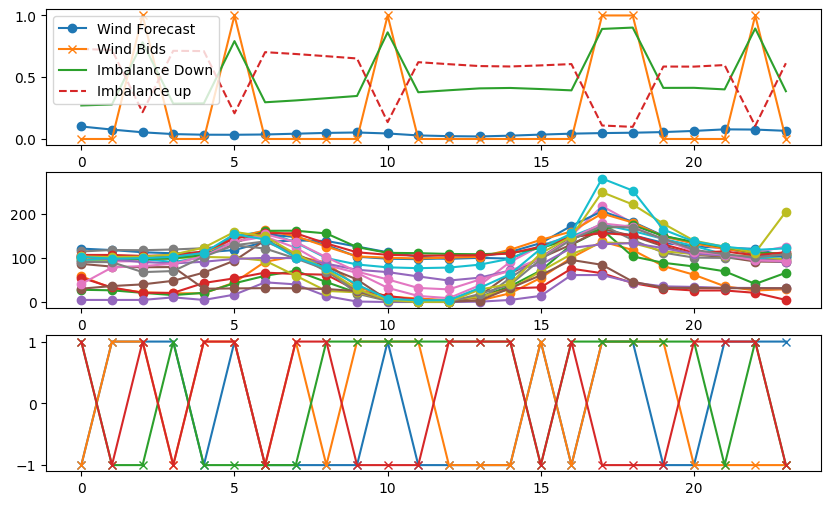

In [6]:
# Visualize the selected wind bids
plt.figure(figsize=(10, 6))
plt.subplot(311)
plt.plot(wind_forecast[:,:1], label='Wind Forecast', marker='o')
plt.plot(wind_bids, label='Wind Bids', marker='x')
plt.plot(imbalances_down[:,:1], label='Imbalance Down')
plt.plot(imbalances_up[:,:1], label='Imbalance up', linestyle='--')
plt.legend()
plt.subplot(312)
plt.plot(spot_forecast[:,:n1], label='Spot Prices', marker='o')
plt.subplot(313)
plt.plot(imbalance_forecast[:,:n3], label='Imbalance Prices', marker='x')

Expected Profit:  433.02788169952817


Text(0.5, 1.0, 'Cumulative Distribution Function of Profit')

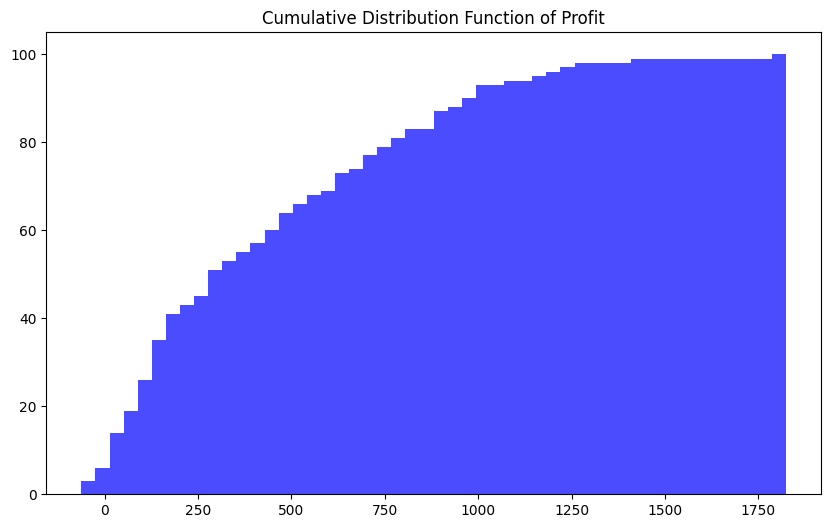

In [7]:
# compute profit of in-sample scenarios
# Compute the profit over all scenarios
profit = np.zeros((n_scenarios, 1))
for i in range(n_scenarios):
        profit[i] = wpb.compute_profit(wind_bids, wind_forecast[:, scenarios_id[i, 0]], spot_forecast[:,scenarios_id[i, 1]], imbalance_forecast[:, scenarios_id[i, 2]], f_down, f_up, 'one_price')

# flatten profit array
profit_flat = profit.flatten()
# Sort the profit array
profit_sorted = np.sort(profit_flat)
# Compute the expected profit
expected_profit = np.mean(profit_sorted)
print("Expected Profit: ", expected_profit)
# Visualize the cumulative distribution function (CDF)
plt.figure(figsize=(10, 6))
plt.hist(profit_sorted, bins=50, cumulative=True, color='blue', alpha=0.7)
plt.title('Cumulative Distribution Function of Profit')

# 2) Two-price scheme

In [8]:
wind_bids, prob, imbalances, imbalances_up, imbalances_down= wpb.wind_pp_bidding(wind_forecast[:, scenarios_id[:, 0]], spot_forecast[:, scenarios_id[:, 1]], imbalance_forecast[:, scenarios_id[:, 2]], f_up, f_down, price_scheme='two_price')

/opt/homebrew/lib/python3.11/site-packages/cvxpy/problems/problem.py:158: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "


Objective value:  361.933077616343


/opt/homebrew/lib/python3.11/site-packages/mosek/__init__.py:18617: UserWarning: Argument sub in putvarboundlist: Incorrect array format causing data to be copied
  warnings.warn("Argument sub in putvarboundlist: Incorrect array format causing data to be copied");
/opt/homebrew/lib/python3.11/site-packages/mosek/__init__.py:18925: UserWarning: Argument subj in putclist: Incorrect array format causing data to be copied
  warnings.warn("Argument subj in putclist: Incorrect array format causing data to be copied");
/opt/homebrew/lib/python3.11/site-packages/mosek/__init__.py:18349: UserWarning: Argument sub in putconboundlist: Incorrect array format causing data to be copied
  warnings.warn("Argument sub in putconboundlist: Incorrect array format causing data to be copied");


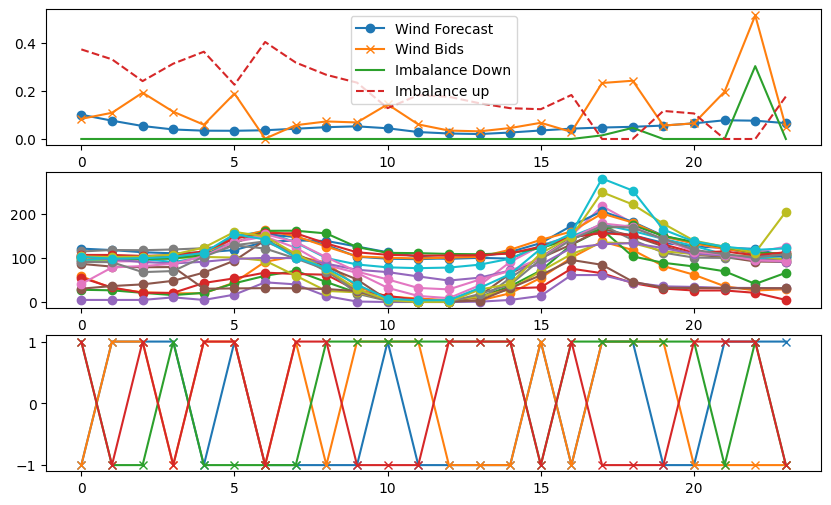

In [9]:
# Visualize the selected wind bids
plt.figure(figsize=(10, 6))
plt.subplot(311)
plt.plot(wind_forecast[:,:1], label='Wind Forecast', marker='o')
plt.plot(wind_bids, label='Wind Bids', marker='x')
plt.plot(imbalances_down[:,:1], label='Imbalance Down')
plt.plot(imbalances_up[:,:1], label='Imbalance up', linestyle='--')
plt.legend()
plt.subplot(312)
plt.plot(spot_forecast[:,:n1], label='Spot Prices', marker='o')
plt.subplot(313)
plt.plot(imbalance_forecast[:,:n3], label='Imbalance Prices', marker='x')

Expected Profit:  400.9939523807131


Text(0.5, 1.0, 'Cumulative Distribution Function of Profit')

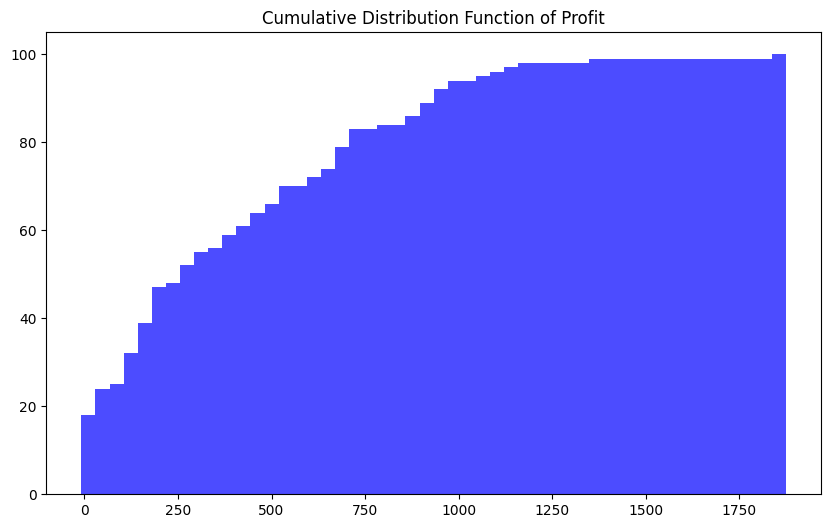

In [10]:
# compute profit of in-sample scenarios
# Compute the profit over all scenarios
profit = np.zeros((n_scenarios, 1))
for i in range(n_scenarios):
        profit[i] = wpb.compute_profit(wind_bids, wind_forecast[:, scenarios_id[i, 0]], spot_forecast[:,scenarios_id[i, 1]], imbalance_forecast[:, scenarios_id[i, 2]], f_down, f_up, 'one_price')

# flatten profit array
profit_flat = profit.flatten()
# Sort the profit array
profit_sorted = np.sort(profit_flat)
# Compute the expected profit
expected_profit = np.mean(profit_sorted)
print("Expected Profit: ", expected_profit)
# Visualize the cumulative distribution function (CDF)
plt.figure(figsize=(10, 6))
plt.hist(profit_sorted, bins=50, cumulative=True, color='blue', alpha=0.7)
plt.title('Cumulative Distribution Function of Profit')

# 3) Ex-Post analysis

In [11]:
def k_fold_cross_validation(wind_forecast, spot_forecast, imbalance_forecast, shuffled_scenarios, f_up, f_down, scheme='one_price', reps=8):

    print("Performing k-fold cross-validation with {} folds...".format(reps))
    print("Price scheme: ", scheme)
    fold_size = len(shuffled_scenarios) // reps # should assert divisibility
    expected_in_profits = np.zeros((reps, 1))
    expected_out_profits = np.zeros((reps, 1))
    for k in range(reps):
        in_sample_scenarios = shuffled_scenarios[k*fold_size:(k+1)*fold_size, :] # since we shuffled scenarios, we can just take the fold_size scenarios from k*fold_size onwards
        out_sample_scenarios = np.delete(shuffled_scenarios, np.s_[k*fold_size:(k+1)*fold_size], axis=0) # delete in-sample scenarios from the shuffled scenarios

        # compute wind bids, only use in-sample scenarios
        wind_bids, _, _, _, _= wpb.wind_pp_bidding(wind_forecast[:, in_sample_scenarios[:, 0]], spot_forecast[:, in_sample_scenarios[:, 1]], imbalance_forecast[:, in_sample_scenarios[:, 2]], f_up, f_down, price_scheme=scheme)
        
        # compute profits 
        profits_in_sample = np.zeros((len(in_sample_scenarios), 1))
        for i in range(len(in_sample_scenarios)):
            # compute profits for in-sample scenarios
            profits_in_sample[i] = wpb.compute_profit(wind_bids, wind_forecast[:, in_sample_scenarios[i, 0]], spot_forecast[:, in_sample_scenarios[i, 1]], imbalance_forecast[:, in_sample_scenarios[i, 2]], f_down, f_up, scheme)
        profits_out_sample = np.zeros((len(out_sample_scenarios), 1))
        
        for i in range(len(out_sample_scenarios)):
            # compute profits for out-of-sample scenarios
            profits_out_sample[i] = wpb.compute_profit(wind_bids, wind_forecast[:, out_sample_scenarios[i, 0]], spot_forecast[:, out_sample_scenarios[i, 1]], imbalance_forecast[:, out_sample_scenarios[i, 2]], f_down, f_up, scheme)
        
        expected_in_profits[k] = np.mean(profits_in_sample)
        expected_out_profits[k] = np.mean(profits_out_sample)

    return expected_in_profits, expected_out_profits, profits_in_sample, profits_out_sample

## One Price

In [12]:
expected_in_profits, expected_out_profits, _, _ = k_fold_cross_validation(wind_forecast, spot_forecast, imbalance_forecast, shuffled_scenarios, f_up, f_down, scheme='one_price', reps=8)

Performing k-fold cross-validation with 8 folds...
Price scheme:  one_price


/opt/homebrew/lib/python3.11/site-packages/cvxpy/problems/problem.py:158: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "
/opt/homebrew/lib/python3.11/site-packages/mosek/__init__.py:18617: UserWarning: Argument sub in putvarboundlist: Incorrect array format causing data to be copied
  warnings.warn("Argument sub in putvarboundlist: Incorrect array format causing data to be copied");
/opt/homebrew/lib/python3.11/site-packages/mosek/__init__.py:18925: UserWarning: Argument subj in putclist: Incorrect array format causing data to be copied
  warnings.warn("Argument subj in putclist: Incorrect array format causing data to be copied");
/opt/homebrew/lib/python3.11/site-packages/mosek/__init__.py:18349: UserWarning: Argument sub in putconboundlist: Incorrect array format causing data to be copied
  warnings.warn("Argument sub in putconboundlist: Incorrect arr

Objective value:  455.84033750087525
Objective value:  423.05230252349855
Objective value:  505.5691476010778
Objective value:  474.94036049574953
Objective value:  454.3804570166524
Objective value:  422.8723517809233
Objective value:  419.699078892971
Objective value:  448.9438776811599


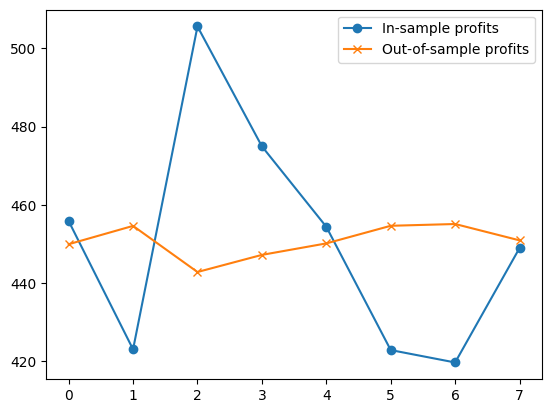

In [13]:
plt.plot(expected_in_profits, label='In-sample profits', marker='o')
plt.plot(expected_out_profits, label='Out-of-sample profits', marker='x')
plt.legend()

## Two-Price

In [14]:
expected_in_profits, expected_out_profits, _, _ = k_fold_cross_validation(wind_forecast, spot_forecast, imbalance_forecast, shuffled_scenarios, f_up, f_down, 'two_price', 8)

Performing k-fold cross-validation with 8 folds...
Price scheme:  two_price


/opt/homebrew/lib/python3.11/site-packages/cvxpy/problems/problem.py:158: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "
/opt/homebrew/lib/python3.11/site-packages/mosek/__init__.py:18617: UserWarning: Argument sub in putvarboundlist: Incorrect array format causing data to be copied
  warnings.warn("Argument sub in putvarboundlist: Incorrect array format causing data to be copied");
/opt/homebrew/lib/python3.11/site-packages/mosek/__init__.py:18925: UserWarning: Argument subj in putclist: Incorrect array format causing data to be copied
  warnings.warn("Argument subj in putclist: Incorrect array format causing data to be copied");
/opt/homebrew/lib/python3.11/site-packages/mosek/__init__.py:18349: UserWarning: Argument sub in putconboundlist: Incorrect array format causing data to be copied
  warnings.warn("Argument sub in putconboundlist: Incorrect arr

Objective value:  385.0442055165376
Objective value:  360.9903279416083
Objective value:  424.4639888984426
Objective value:  401.55702524399004
Objective value:  384.8842800367432
Objective value:  360.83523487038553
Objective value:  354.8062678073087
Objective value:  379.08238426247885


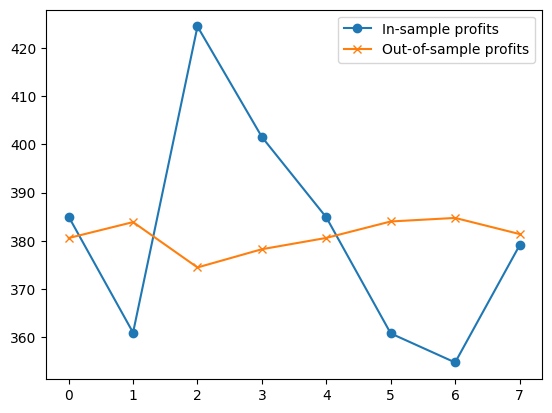

In [15]:
plt.plot(expected_in_profits, label='In-sample profits', marker='o')
plt.plot(expected_out_profits, label='Out-of-sample profits', marker='x')
plt.legend()

# 4) Risk adverse bidding strategy

In [39]:
# nb_scenarios to consider
n_scenarios = 100
scenarios_id = shuffled_scenarios[:n_scenarios, :] # take the first n_scenarios as the in-sample scenarios

In [40]:
scheme = 'one_price'
wind_bids_ra, prob_ra, imbalances_ra, imbalances_up_ra, imbalances_down_ra, expected_profit, cvar = wpb.wind_pp_bidding_ra(wind_forecast[:, scenarios_id[:, 0]], spot_forecast[:, scenarios_id[:, 1]], imbalance_forecast[:, scenarios_id[:, 2]], f_up, f_down, alpha=0.95, beta = 0, price_scheme=scheme)
# check : with beta = 0, the results should be the same as the previous res for selected price scheme
# NOTE: we chose the (1-beta)*p + beta*cvar objective, so 0<=beta<=1

/opt/homebrew/lib/python3.11/site-packages/cvxpy/problems/problem.py:158: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "


Objective value:  433.02788169952834


In [41]:
cvar, expected_profit

(-62.14845137709188, 433.02788169952834)

In [42]:
wind_bids_ra, prob_ra, imbalances_ra, imbalances_up_ra, imbalances_down_ra, expected_profit, cvar = wpb.wind_pp_bidding_ra(wind_forecast[:, scenarios_id[:, 0]], spot_forecast[:, scenarios_id[:, 1]], imbalance_forecast[:, scenarios_id[:, 2]], f_up, f_down, alpha=0.95, beta = 0.95, price_scheme=scheme)

Objective value:  31.745409081060316


In [43]:
cvar, expected_profit

(11.52058178135709, 416.0171277754213)

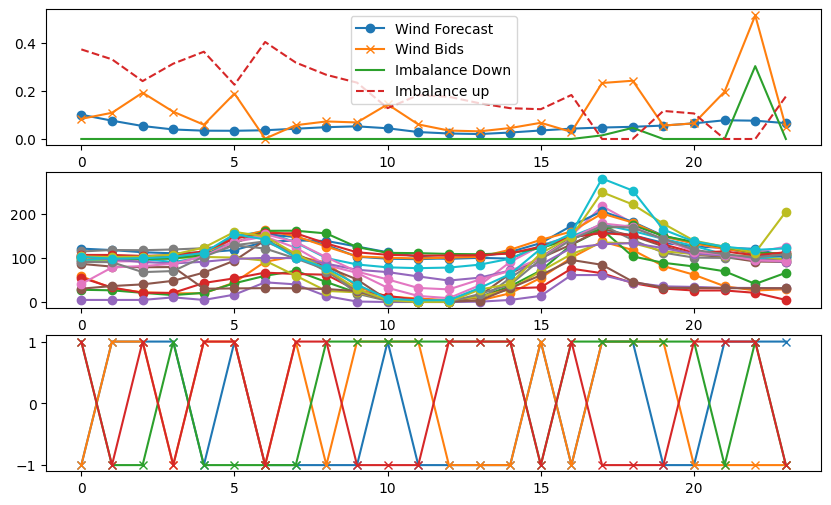

In [44]:
# Visualize the selected wind bids
plt.figure(figsize=(10, 6))
plt.subplot(311)
plt.plot(wind_forecast[:,:1], label='Wind Forecast', marker='o')
plt.plot(wind_bids, label='Wind Bids', marker='x')
plt.plot(imbalances_down[:,:1], label='Imbalance Down')
plt.plot(imbalances_up[:,:1], label='Imbalance up', linestyle='--')
plt.legend()
plt.subplot(312)
plt.plot(spot_forecast[:,:n1], label='Spot Prices', marker='o')
plt.subplot(313)
plt.plot(imbalance_forecast[:,:n3], label='Imbalance Prices', marker='x')

Expected Profit:  400.9939523807131


Text(0.5, 1.0, 'Cumulative Distribution Function of Profit')

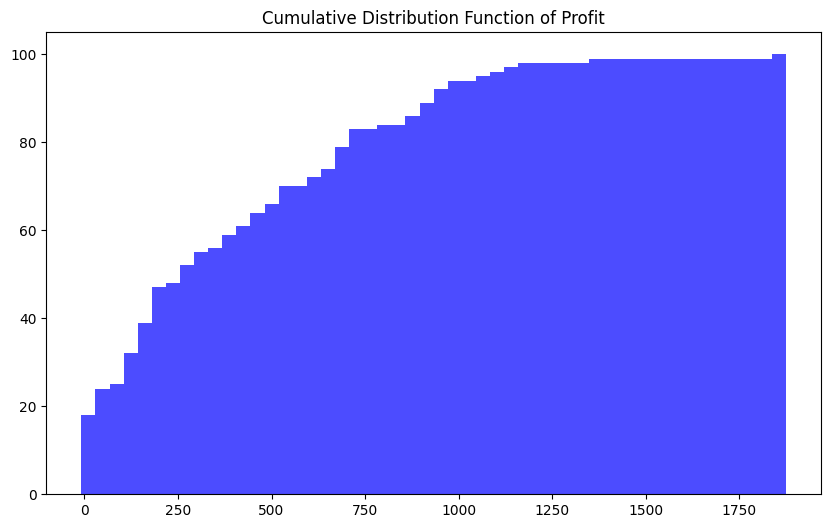

In [45]:
# compute profit of in-sample scenarios
# Compute the profit over all scenarios
profit = np.zeros((n_scenarios, 1))
for i in range(n_scenarios):
        profit[i] = wpb.compute_profit(wind_bids, wind_forecast[:, scenarios_id[i, 0]], spot_forecast[:,scenarios_id[i, 1]], imbalance_forecast[:, scenarios_id[i, 2]], f_down, f_up, scheme)

# flatten profit array
profit_flat = profit.flatten()
# Sort the profit array
profit_sorted = np.sort(profit_flat)
# Compute the expected profit
expected_profit = np.mean(profit_sorted)
print("Expected Profit: ", expected_profit)
# Visualize the cumulative distribution function (CDF)
plt.figure(figsize=(10, 6))
plt.hist(profit_sorted, bins=50, cumulative=True, color='blue', alpha=0.7)
plt.title('Cumulative Distribution Function of Profit')

In [46]:
# pareto frontier
n_points = 10
betas = np.linspace(0, 1-1/n_points, n_points)
exp_profs, cvars = list(), list()

for beta in betas:
    print("beta: ", beta)
    _, _, _, _, _, expected_profit, cvar = wpb.wind_pp_bidding_ra(wind_forecast[:, scenarios_id[:, 0]], spot_forecast[:, scenarios_id[:, 1]], imbalance_forecast[:, scenarios_id[:, 2]], f_up, f_down, alpha=0.95, beta=beta, price_scheme=scheme)
    exp_profs.append(expected_profit)
    cvars.append(cvar)

beta:  0.0
Objective value:  433.02788169952834
beta:  0.1
Objective value:  386.57937711482197
beta:  0.2
Objective value:  340.3420565781546
beta:  0.30000000000000004
Objective value:  297.7425001341417
beta:  0.4
Objective value:  256.1179132780062
beta:  0.5
Objective value:  215.08870792096528
beta:  0.6000000000000001
Objective value:  174.05950253480577
beta:  0.7000000000000001
Objective value:  133.20138002492112
beta:  0.8
Objective value:  92.54933276575548
beta:  0.9
Objective value:  51.97037927233825


Text(0, 0.5, 'Expected Profit')

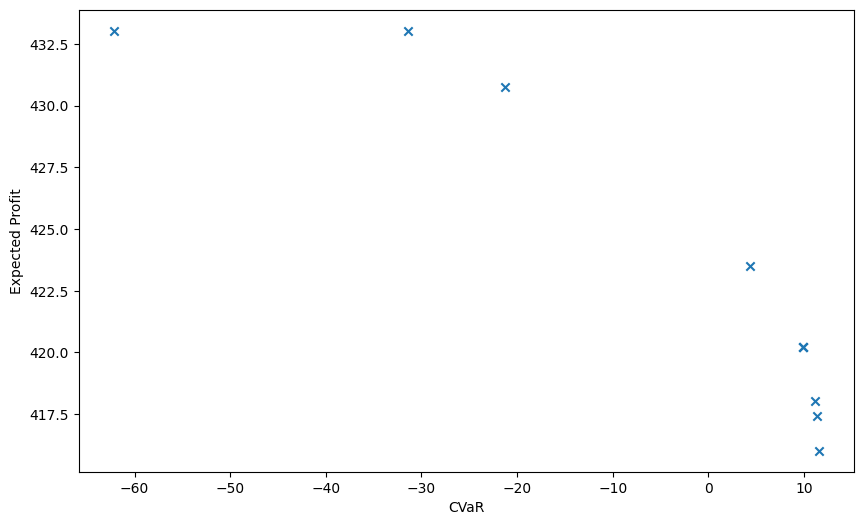

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(cvars, exp_profs, label='Pareto Frontier', marker='x')
plt.xlabel('CVaR')
plt.ylabel('Expected Profit')

In [69]:
# study volatility with scenarios
# first increase amount of scenarios
nbs = np.linspace(10, 500, 10, dtype=int)
beta = 0.95 # high risk aversion
xpected_profits, cvars = list(), list()

for nb in nbs:
    scenarios_id = shuffled_scenarios[:nb, :] # take the first n_scenarios as the in-sample scenarios
    _, _, _, _, _, expected_profit, cvar = wpb.wind_pp_bidding_ra(wind_forecast[:, scenarios_id[:, 0]], spot_forecast[:, scenarios_id[:, 1]], imbalance_forecast[:, scenarios_id[:, 2]], f_up, f_down, alpha=0.95, beta=0.95, price_scheme=scheme)
    xpected_profits.append(expected_profit)
    cvars.append(cvar)

/opt/homebrew/lib/python3.11/site-packages/mosek/__init__.py:18617: UserWarning: Argument sub in putvarboundlist: Incorrect array format causing data to be copied
  warnings.warn("Argument sub in putvarboundlist: Incorrect array format causing data to be copied");
/opt/homebrew/lib/python3.11/site-packages/mosek/__init__.py:18925: UserWarning: Argument subj in putclist: Incorrect array format causing data to be copied
  warnings.warn("Argument subj in putclist: Incorrect array format causing data to be copied");
/opt/homebrew/lib/python3.11/site-packages/mosek/__init__.py:18349: UserWarning: Argument sub in putconboundlist: Incorrect array format causing data to be copied
  warnings.warn("Argument sub in putconboundlist: Incorrect array format causing data to be copied");
/opt/homebrew/lib/python3.11/site-packages/cvxpy/problems/problem.py:158: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objecti

Objective value:  75.21907696545615
Objective value:  38.29194760801008
Objective value:  38.00062134427578
Objective value:  32.034448171030114
Objective value:  28.15677566064945
Objective value:  28.61886161509686
Objective value:  29.385207714672415
Objective value:  29.467001202200358
Objective value:  29.802528228914447
Objective value:  29.811174494230485


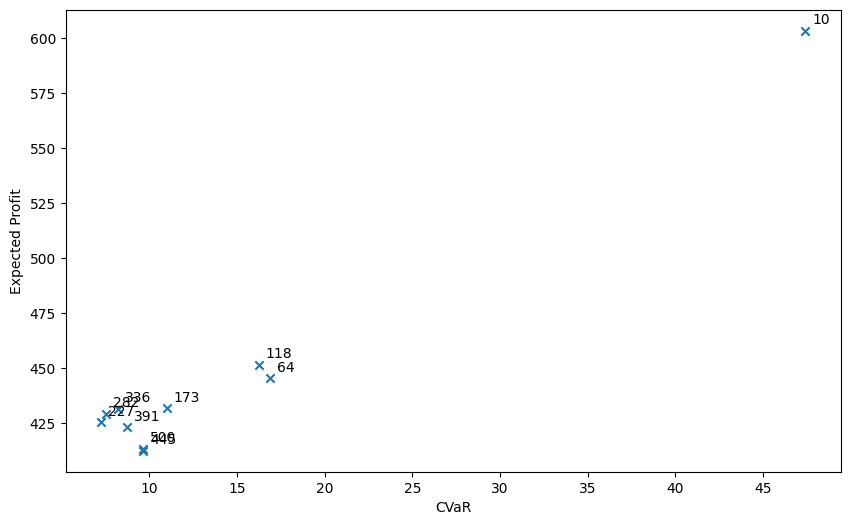

In [70]:
plt.figure(figsize=(10, 6))
plt.scatter(cvars, xpected_profits, label=nbs, marker='x')
plt.xlabel('CVaR')
plt.ylabel('Expected Profit')
# Annotate each point
for i in range(len(cvars)):
    plt.annotate(nbs[i], (cvars[i], xpected_profits[i]), textcoords="offset points", xytext=(5,5), ha='left')

In [72]:
# select sufficient amt of scenarios for cvar not to be volatile (using previous figure)
# now shuffle scenarios randomly and solve bidding problem
nsc = 200
n_shuffles = 10
xpected_profits, cvars = list(), list()

for i in range(n_shuffles):
    shuffled_scenarios = np.random.permutation(combined_scenarios)
    scenarios_id = shuffled_scenarios[:nsc, :] # take the first n_scenarios as the in-sample scenarios
    _, _, _, _, _, expected_profit, cvar = wpb.wind_pp_bidding_ra(wind_forecast[:, scenarios_id[:, 0]], spot_forecast[:, scenarios_id[:, 1]], imbalance_forecast[:, scenarios_id[:, 2]], f_up, f_down, alpha=0.95, beta=0.95, price_scheme=scheme)
    xpected_profits.append(expected_profit)
    cvars.append(cvar)

Objective value:  37.2871848264444
Objective value:  38.01728667554303
Objective value:  35.0364875706091
Objective value:  30.838250946996627
Objective value:  37.359184903243474
Objective value:  34.59735755780788
Objective value:  37.711745322579056
Objective value:  34.88140019209398
Objective value:  31.95529919073688
Objective value:  29.626263863567644


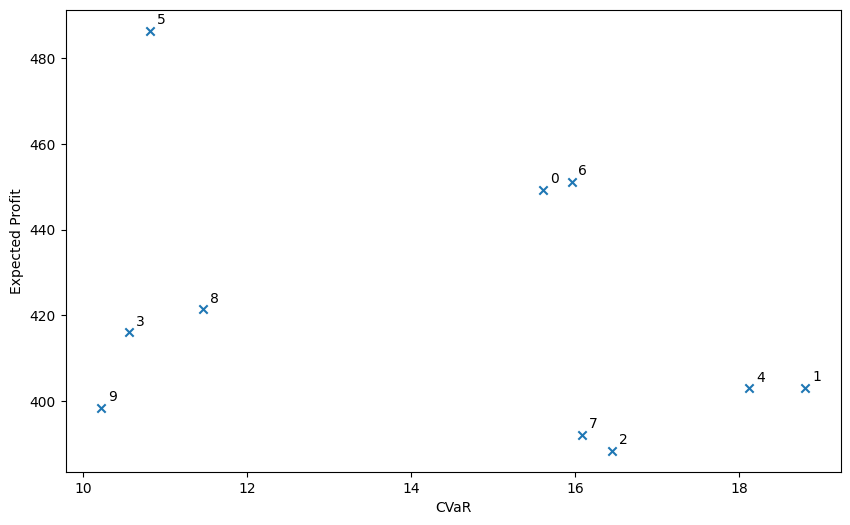

In [73]:
plt.figure(figsize=(10, 6))
plt.scatter(cvars, xpected_profits, label=nbs, marker='x')
plt.xlabel('CVaR')
plt.ylabel('Expected Profit')
# Annotate each point
for i in range(len(cvars)):
    plt.annotate(range(n_shuffles)[i], (cvars[i], xpected_profits[i]), textcoords="offset points", xytext=(5,5), ha='left')